In [1]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as time

In [2]:
from crea_tabla import *

In [3]:
frame = 30
datos_1, originales = obtén_tabla_datos(conjuntos=frame, rescale = 0.25)
datos_1.drop(['f'], axis = 1, inplace = True)

# Imagen original (RGB) del frame seleccionado
original_shape = originales[frame][:,:,:3].shape
original = datos_1[['R', 'G', 'B']].to_numpy().reshape(original_shape)

Leyendo numpy...
Organizando renglones...
Creando tabla de datos...
Terminado


# Primer acercamiento a DBSCAN

In [4]:
def test_dbscan(datos, original):
    '''
    datos : Array de características de los datos (n,8)
    original: Array de la imagen original  con shape (h,w,3)
    '''
    ## Estandarización
    stscaler = StandardScaler().fit(datos)
    np_datos_escalados = stscaler.transform(datos)

    # Entrenamiento de DBSCAN
    min_samples = int(len(np_datos_escalados) * 0.01)
    t_ini = time.time()
    dbsc = DBSCAN(eps = .5, min_samples = min_samples).fit(np_datos_escalados)
    print(f"Tiempo transcurrido: {time.time() - t_ini:.3f}s")


    # Máscaras resultantes
    labels = dbsc.labels_
    core_samples = np.zeros_like(labels, dtype = bool)
    core_samples[dbsc.core_sample_indices_] = True

    # Visualización
    rens = originales[0].shape[0]
    cols = originales[0].shape[1]
    grupos = labels.reshape((rens, cols))

    fig,ax = plt.subplots(1,2, figsize = (10, 20))

    ax[0].imshow(original.astype(int))
    im = ax[1].imshow(grupos)
    pass

### DBSCAN

Tiempo transcurrido: 12.259s


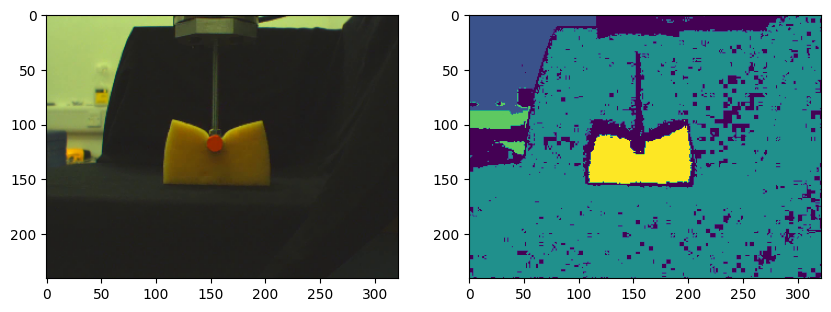

In [5]:
test_dbscan(datos_1, original)

El primer resultado de DBSCAN con los hiperparámetros establecidos muestra que, si bien el modelo identifica la esponja en su mayoría, tiene problemas con las regiones donde hay reflejo de luz (debido a la posición de la fuente de luz). Para arreglar esto, se podría hacer un tratamiento de las imágenes antes de alimentar a DBSCAN, suavizando el valor de los canales de color con filtros como el Gaussiano, o usando otros compuestos enfocados en corregir la iluminación.

# Preprocesamiento

## Shading Correction

In [241]:
# Transformar a escala de grises
original_bgr = original[...,[2,1,0]].astype(np.uint8)
gray = cv.cvtColor(original_bgr, cv.COLOR_BGR2GRAY)

# Aplicar suavizado Gaussiano para obtener el mapa de iluminación
illumination_map = cv.GaussianBlur(gray, (55, 55), cv.BORDER_DEFAULT)

# Normalizar la imagen
image_normalized = cv.divide(gray, illumination_map, scale=255)

# Convertir la imagen normalizada a BGR si es necesario
image_bgr = cv.cvtColor(image_normalized, cv.COLOR_GRAY2BGR)

### Transformación

In [242]:
# Expresar resultado en 6 canales (RGB|HSV)
cuadro_hsv = cv.cvtColor(image_bgr, cv.COLOR_BGR2HSV)
image_bgr_6channel = np.dstack((image_bgr, cuadro_hsv))

In [243]:
# Obtener expresión adecuada para el algoritmo
image_4d = image_bgr_6channel[np.newaxis, ...]
arreglo_datos = crea_arreglo_datos(image_4d)
print("Creando tabla de datos...")
tabla_datos = pd.DataFrame(data=arreglo_datos,
                        columns=('f','i','j','B','G','R','H','S','V'))
tabla_datos.drop(['f'], axis = 1, inplace = True)

Creando tabla de datos...


### DBSCAN

Tiempo transcurrido: 9.293s


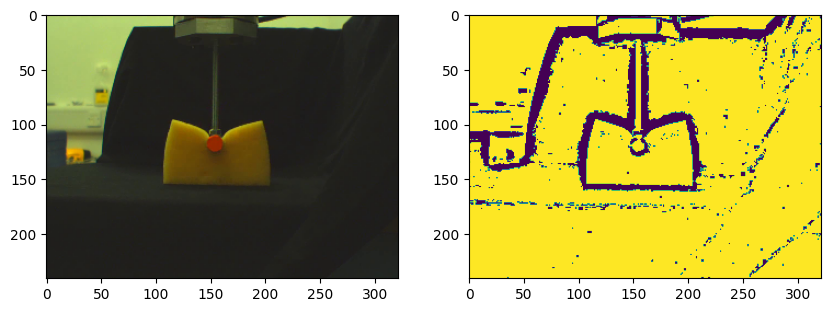

In [244]:
test_dbscan(tabla_datos, original)

En este caso, el filtro está normalizando el brillo y resaltando los bordes. Parece ser uno de los pasos que se buscaban; separar los bordes de la esponja sin importar la luminocidad de sus regiones.

Esto también podría indicar que si se ignora la luminosidad o se normaliza (el canal V, o B en el espacio LAB), se podría tener una mejor clusterización.

## Filtro Gaussiano

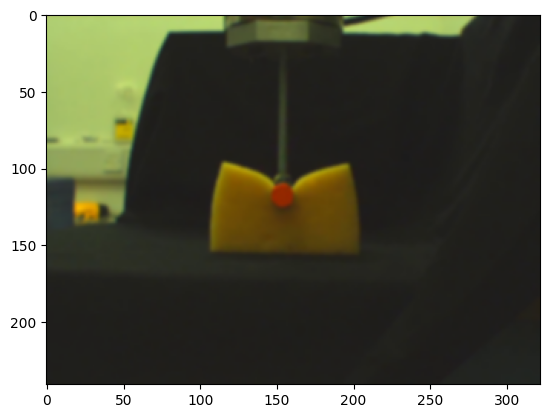

In [245]:
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Kernel Gaussiano 5x5
kernel_gauss_5 = np.array([[1,  4,  6,  4, 1],
                            [4, 16, 24, 16, 4],
                            [6, 24, 36, 24, 6],
                            [4, 16, 24, 16, 4],
                            [1,  4,  6,  4, 1]]) / 256
kernel_gauss_3 = np.array([[1,  2,  1],
                            [2, 4, 2],
                            [1,  2,  1]]) / 256


# Aplicar la convolución 2D para cada canal
image_smoothed = np.zeros_like(original)
for i in range(3):
    image_smoothed[..., i] = convolve2d(original[..., i], kernel_gauss_5, boundary='symm', mode='same')

image_smoothed = image_smoothed.astype(np.uint8)
plt.imshow(image_smoothed)
plt.show()

### Transformación

In [246]:
# Expresar resultado en 6 canales (RGB|HSV)
image_smoothed_bgr = image_smoothed[...,[2,1,0]]
cuadro_hsv = cv.cvtColor(image_smoothed_bgr, cv.COLOR_BGR2HSV)
image_smoothed_6channel = np.dstack((image_smoothed_bgr, cuadro_hsv))

In [247]:
# Obtener expresión adecuada para el algoritmo
image_4d = image_smoothed_6channel[np.newaxis, ...]
arreglo_datos = crea_arreglo_datos(image_4d)
print("Creando tabla de datos...")
tabla_datos = pd.DataFrame(data=arreglo_datos,
                        columns=('f','i','j','B','G','R','H','S','V'))
tabla_datos.drop(['f'], axis = 1, inplace = True)

Creando tabla de datos...


### DBSCAN

Tiempo transcurrido: 9.794s


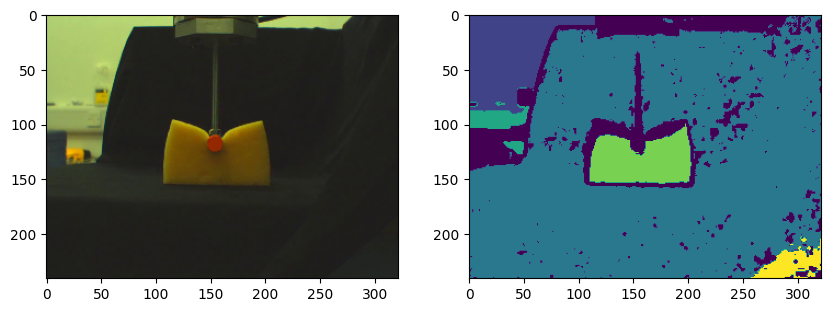

In [248]:
test_dbscan(tabla_datos, original)

La imagen con suavizado parece no ser muy distinta a la original, pero al aplicar DBSCAN sí hace un mejor trabajo encontrando los bordes de cada grupo y suavizando los grupos. Sin embargo, se sigue perdiendo la región con distina luminocidad.

Quizás este filtro se pueda aplicar después de un tratamiento de saturación o brillo.

## Filtro Gaussiano + Ignorar Características

Con lo aprendido de los dos análisis anteriores, si tanto el espacio RGB como HSV describen el espacio de color de la imagen y ya se observó que la luminocidad de algunas regiones evita una correcta clusterización, entonces es probable que eliminando el canal `V` ayude a identificar mejor a la esponja.

El problema siguiente será que el espacio RGB aún tendrá esta información, por lo que se probará también eliminando los canales `R`, `G` y `B`; así también se probará combinaciones con la saturación `S`.

### Sin V y S

Tiempo transcurrido: 7.720s


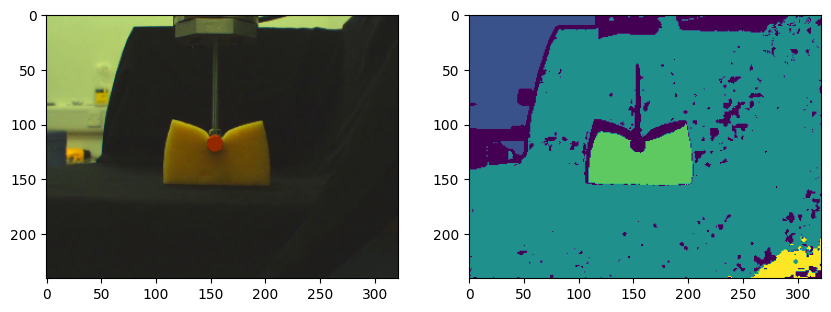

In [ ]:
datos = tabla_datos.drop(['V', 'S'], axis=1)
test_dbscan(datos, original)

### Sin V

Tiempo transcurrido: 9.046s


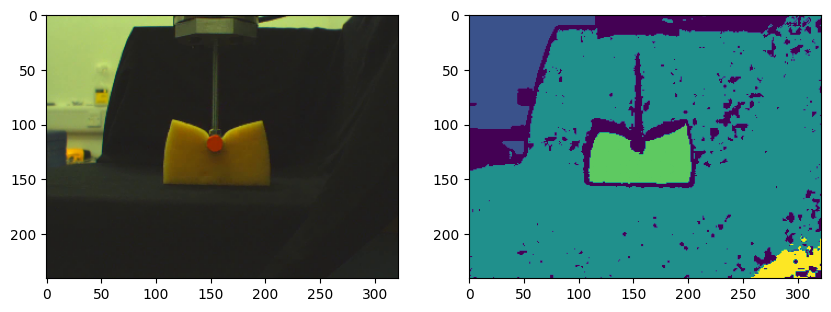

In [ ]:
datos = tabla_datos.drop(['V'], axis=1)
test_dbscan(datos, original)

### Sin S

Tiempo transcurrido: 8.928s


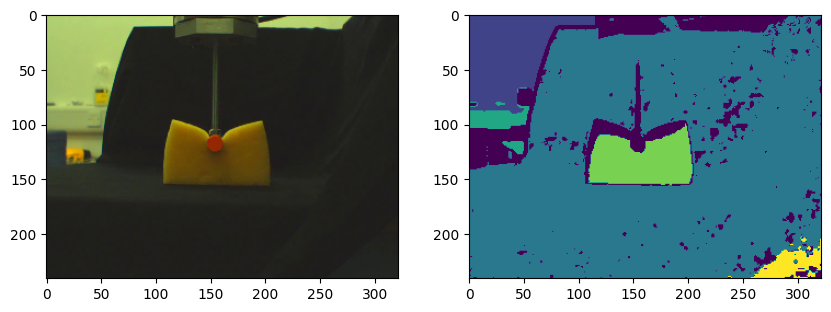

In [ ]:
datos = tabla_datos.drop(['S'], axis=1)
test_dbscan(datos, original)

### Sin R, G y B

Tiempo transcurrido: 6.950s


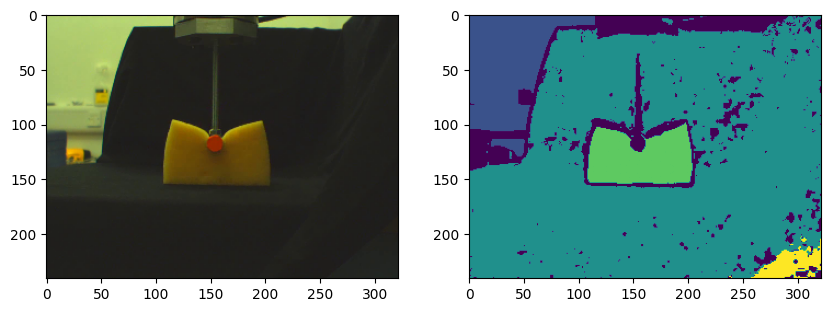

In [ ]:
datos = tabla_datos.drop(['R', 'G', 'B'], axis=1)
test_dbscan(datos, original)

### Sin V, R, G y B

Tiempo transcurrido: 6.031s


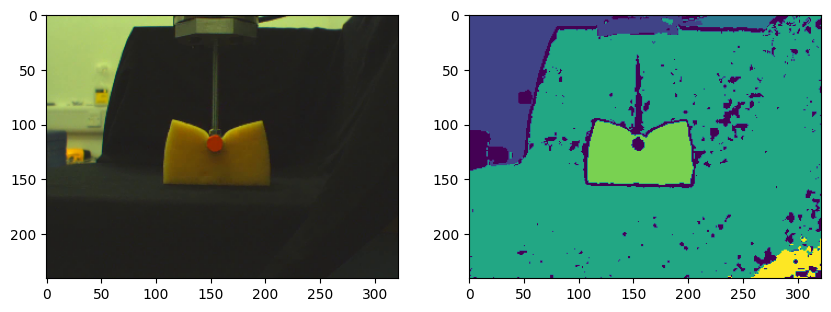

In [ ]:
datos = tabla_datos.drop(['V', 'R', 'G', 'B'], axis=1)
test_dbscan(datos, original)

Parece ser el que mejor se adapta, aunque con errores como la parte entre el bloque de la prensa y el brazo. Pero logra describir totalmente a la esponja. Habría que probar con otras manipulaciones de bordes para definir mejor el brazo hasta tener un resultado equilibrado.

## Filtro Bilateral

In [80]:
# Aplicar filtro bilateral
original_bgr = original[...,[2,1,0]].astype(np.uint8)
image_bgr = cv.bilateralFilter(original_bgr, d=75, sigmaColor=75, sigmaSpace=75)

### Transformación

In [118]:
# Expresar resultado en 6 canales (RGB|HSV)
cuadro_hsv = cv.cvtColor(image_bgr, cv.COLOR_BGR2HSV)
image_bgr_6channel = np.dstack((image_bgr, cuadro_hsv))

In [119]:
# Obtener expresión adecuada para el algoritmo
image_4d = image_bgr_6channel[np.newaxis, ...]
arreglo_datos = crea_arreglo_datos(image_4d)
print("Creando tabla de datos...")
tabla_datos = pd.DataFrame(data=arreglo_datos,
                        columns=('f','i','j','B','G','R','H','S','V'))
tabla_datos.drop(['f'], axis = 1, inplace = True)

Creando tabla de datos...


### DBSCAN

Tiempo transcurrido: 5.703s


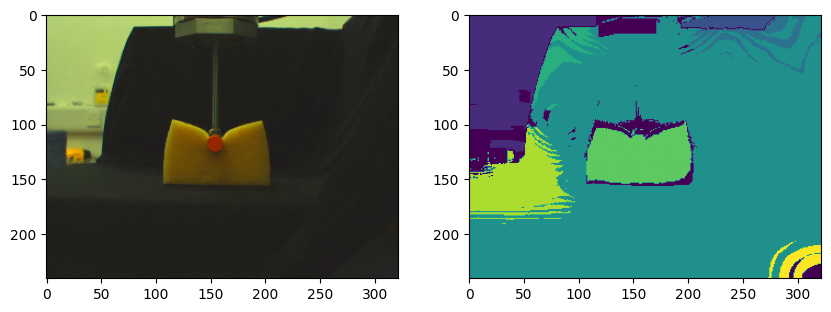

In [83]:
test_dbscan(tabla_datos, original)

Este quizás pueda usarse como máskara para el fondo.